# Оптимизация производственных расходов для металлургического комбината "Стальная птица"

**Описание проекта**: Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать.

**Цель проекта**: Построить модель, которая будет предсказывать температуру сплава исходя из полученных данных.

**Ход проекта**:
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединенного датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общие рекомендации заказчику. Вывод по проекту.

**Вывод** По итогам проведенной работы будет сформирован вывод и составлены рекомендации для заказчика

## Загрузка данных

In [1]:
!pip install xgboost -q
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
folder_path = r'/datasets/' # для тренажера добавить путь '/datasets/'

# Список файлов для загрузки
files_to_load = [
                 'data_arc_new.csv',
                 'data_bulk_new.csv',
                 'data_bulk_time_new.csv',
                 'data_gas_new.csv',
                 'data_temp_new.csv',
                 'data_wire_new.csv',
                 'data_wire_time_new.csv'
                ]

dataframes = {}

for filename in files_to_load:
    file_path = os.path.join(folder_path, filename)

    if os.path.exists(file_path):
        df_name = os.path.splitext(filename)[0]

        if filename.endswith('.csv'):
            dataframes[df_name] = pd.read_csv(file_path)
    else:
        print(f"Файл {filename} не найден")

dataframes.keys()

dict_keys(['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new', 'data_temp_new', 'data_wire_new', 'data_wire_time_new'])

In [4]:
# распакуем словарь, чтобы можно было обращаться к датафреймам по их названию в тетрадке
for name, df in dataframes.items():
    globals()[name] = df

In [5]:
df_list =[data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]

Переименуем названия столбцов в датафреймах, а также изменим тип данных даты

In [6]:
data_bulk_new = data_bulk_new.rename(columns=lambda x: f"bulk_{x.split()[-1]}" if 'Bulk' in x else x)
data_bulk_time_new = data_bulk_time_new.rename(columns=lambda x: f"bulk_{x.split()[-1]}_time" if 'Bulk' in x else x)

data_wire_new = data_wire_new.rename(columns=lambda x: f"wire_{x.split()[-1]}" if 'Wire' in x else x)
data_wire_time_new = data_wire_time_new.rename(columns=lambda x: f"wire_{x.split()[-1]}_time" if 'Wire' in x else x)

data_arc_new.columns = data_arc_new.columns.str.lower().str.replace(' ', '_')
data_gas_new.columns = data_gas_new.columns.str.lower().str.replace(' ', '_')
data_temp_new.columns = data_temp_new.columns.str.lower().str.replace(' ', '_')

In [7]:
data_arc_new[['начало_нагрева_дугой', 'конец_нагрева_дугой']] = \
data_arc_new[['начало_нагрева_дугой', 'конец_нагрева_дугой']].apply(pd.to_datetime)

data_temp_new['время_замера'] = pd.to_datetime(data_temp_new['время_замера'])

data_wire_time_new_list = data_wire_time_new.columns.tolist()[1:]
data_bulk_time_new_list = data_bulk_time_new.columns.tolist()[1:]

data_wire_time_new[data_wire_time_new_list] = data_wire_time_new[data_wire_time_new_list].apply(pd.to_datetime)
data_bulk_time_new[data_bulk_time_new_list] = data_bulk_time_new[data_bulk_time_new_list].apply(pd.to_datetime)

In [8]:
data_arc_new.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [9]:
data_bulk_time_new.head()

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [10]:
data_temp_new.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [11]:
# функция выводит данные о размере датарейме и пропусках в столбцах относительно всего датафрейма,
# а также первые 5 строк

def analyze_dataframes(dataframes):

    for df in df_list:
        display(f"ДАТАФРЕЙМ: {name}")

        display("ПЕРВЫЕ 5 СТРОК:")
        display(df.head())

        display(df.info())

        display(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")

        display("ПУСТЫЕ ЗНАЧЕНИЯ:")
        null_counts = df.isnull().sum()
        null_percentage = (df.isnull().sum() / len(df)) * 100

        null_info = pd.DataFrame({
            'Пустых значений': null_counts,
            'Процент пустых (%)': null_percentage.round(2)
        })

        display(null_info)
        print()


        print("\n" * 2)

analyze_dataframes(dataframes)

'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

'Размер: 14876 строк, 5 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.0
начало_нагрева_дугой,0,0.0
конец_нагрева_дугой,0,0.0
активная_мощность,0,0.0
реактивная_мощность,0,0.0


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

'Размер: 3129 строк, 16 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.00
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

'Размер: 3129 строк, 16 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.00
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

'Размер: 3239 строк, 2 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.0
газ_1,0,0.0


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

'Размер: 18092 строк, 3 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.00
время_замера,0,0.00
температура,3427,18.94


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

'Размер: 3081 строк, 10 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.00
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06


'ДАТАФРЕЙМ: data_wire_time_new'

'ПЕРВЫЕ 5 СТРОК:'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

'Размер: 3081 строк, 10 столбцов'

'ПУСТЫЕ ЗНАЧЕНИЯ:'

,Пустых значений,Процент пустых (%)
key,0,0.00
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06


Данные загрузили, перейдем к исследовательскому анализу и предобработке данных. Мы видим, что нужно будет работать с пустыми значениями, посмотрим, что нас ждет дальше.

## Исследовательский анализ и предобработка данных

Напомним, какие датафремы что у нас содержат:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Нам важно, чтобы для каждого измерения у нас была информация о первой и последней температуре партии - это наш тагрет (строго говоря наш тагрет - именно последняя температура, но нам также важно учесть начальные значения в партии). Поэтому такие партии без температуры мы из датасетов удалим.

Данные о времени нам нужны для того, чтобы объединить все данные в один датафрейм.

Также в наших датасетах значения непрерывные, поэтому мы можем строить гистограммы и различные боксплоты для выявления аномальных значений. Объявим специальную функцию с визуализацией данных.

In [12]:
def eda_func_num_df(dataframes): # для исследования данных выборочных датафреймах
    for df in dataframes:
        display(f"ДАТАФРЕЙМ: {name}")
        df_num = df.select_dtypes(exclude=['object', 'datetime64[ns]'])

        # подграфики для каждого признака
        for column in df_num.iloc[:, 1:]: # убираем номер партии
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # гистограмма (левый график)
            ax1.hist(df_num[column], bins='auto', alpha=0.7, color='skyblue', edgecolor='black')
            ax1.set_title(f'Гистограмма распределения {column}')
            ax1.set_xlabel(f'{column}')
            ax1.set_ylabel('Количество наблюдений, шт.')
            ax1.grid(True, alpha=0.3)

            # диаграмма размаха (правый график)
            ax2.boxplot(df_num[column].dropna(), vert=True)
            ax2.set_title(f'Диаграмма размаха {column}')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # статистическое описание
            Q1 = df_num[column].quantile(0.25)
            Q3 = df_num[column].quantile(0.75)
            IQR = Q3 - Q1

            display(df_num[column].describe())
            display(f"Минимальное значение: {max(0, Q1 - 1.5 * IQR)}")
            display(f"Количество значений меньше нижней границы: {len(df_num[df_num[column] < (Q1 - 1.5 * IQR)])}")
            display(f"Максимальное значение: {Q3 + 1.5 * IQR}")
            display(f"Количество значений больше верхней границы: {len(df_num[df_num[column] > (Q3 + 1.5 * IQR)])}")

'ДАТАФРЕЙМ: data_wire_time_new'

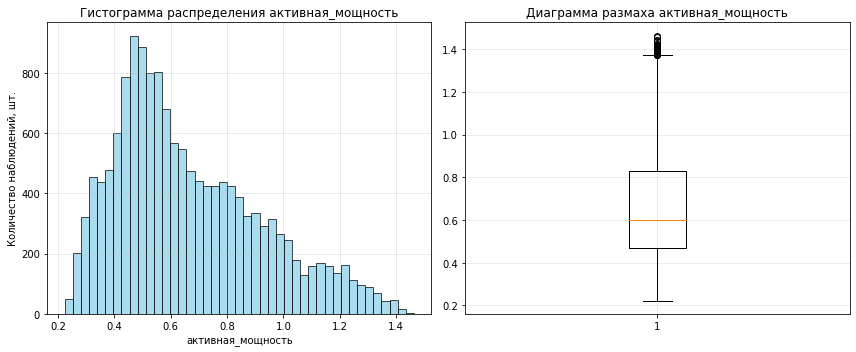

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: активная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.374503125'

'Количество значений больше верхней границы: 72'

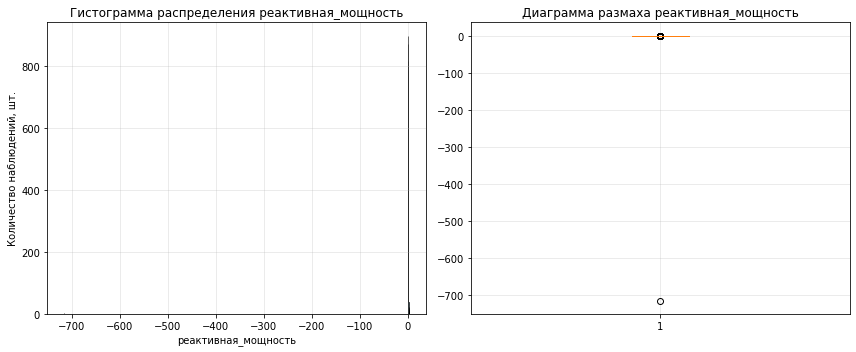

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 1'

'Максимальное значение: 1.0147391250000002'

'Количество значений больше верхней границы: 198'

'ДАТАФРЕЙМ: data_wire_time_new'

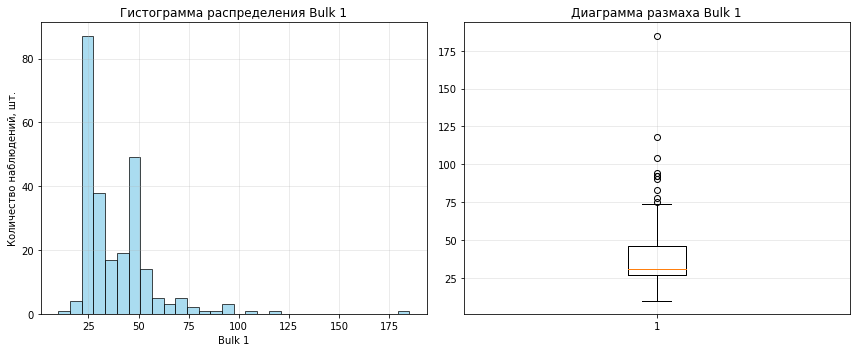

count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 74.5'

'Количество значений больше верхней границы: 10'

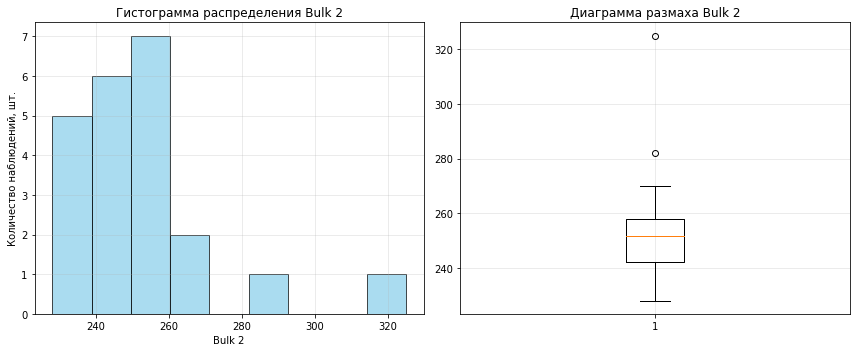

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

'Минимальное значение: 218.375'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 281.375'

'Количество значений больше верхней границы: 2'

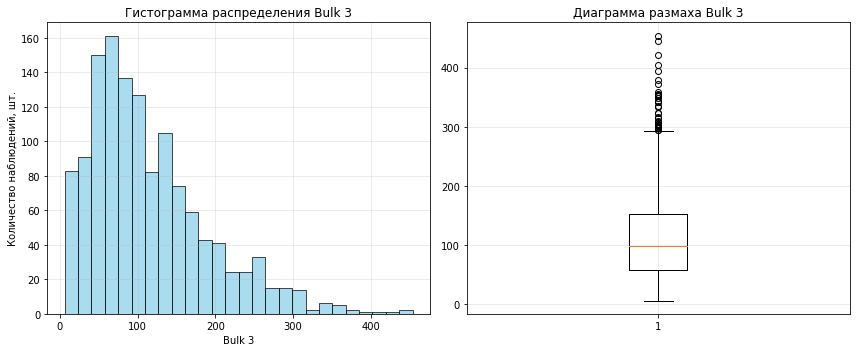

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 293.0'

'Количество значений больше верхней границы: 38'

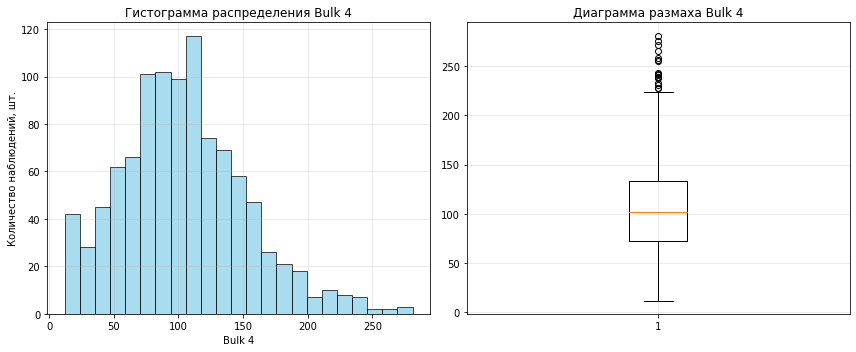

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 224.5'

'Количество значений больше верхней границы: 18'

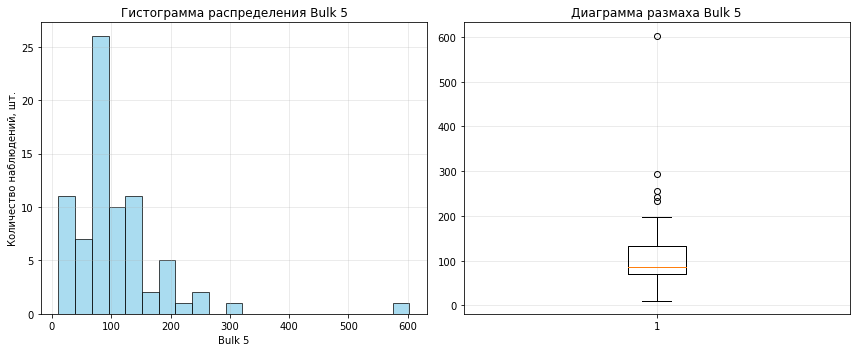

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 225.0'

'Количество значений больше верхней границы: 5'

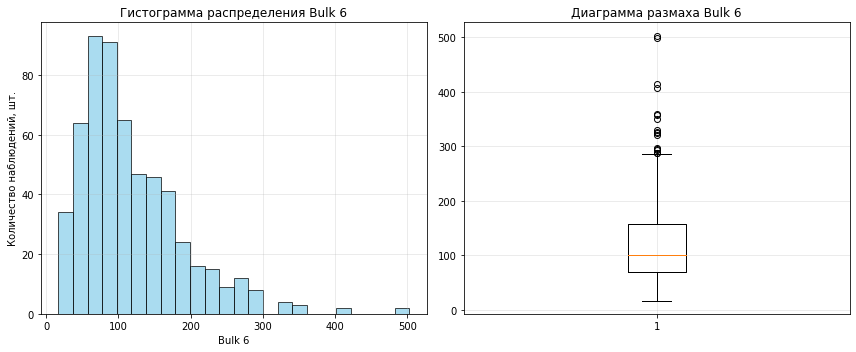

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 287.875'

'Количество значений больше верхней границы: 16'

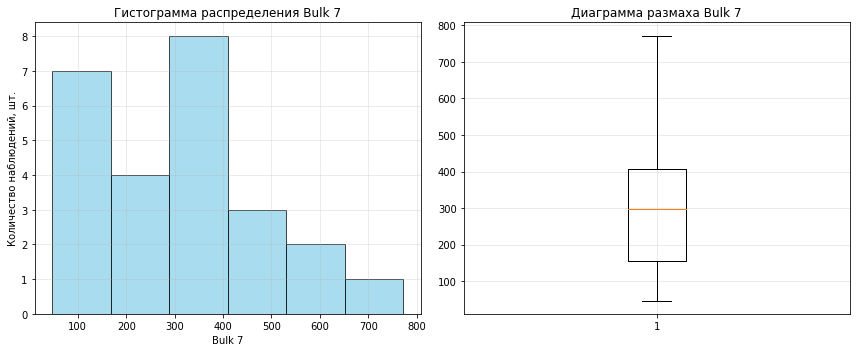

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 782.5'

'Количество значений больше верхней границы: 0'

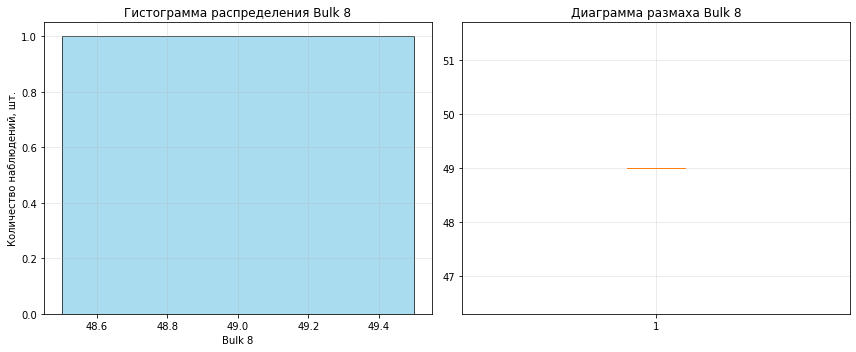

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

'Минимальное значение: 49.0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 49.0'

'Количество значений больше верхней границы: 0'

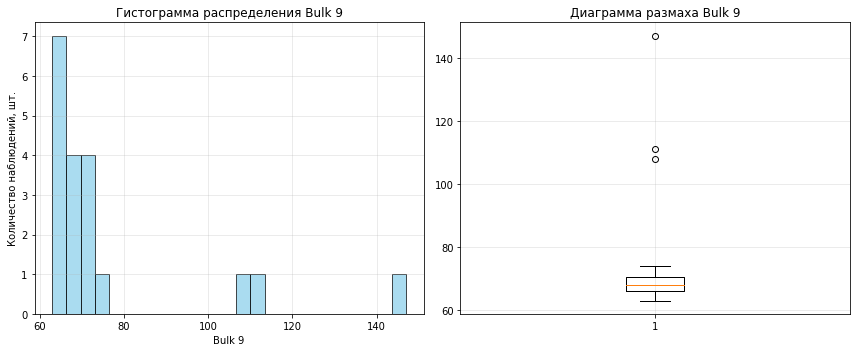

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

'Минимальное значение: 59.25'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 77.25'

'Количество значений больше верхней границы: 3'

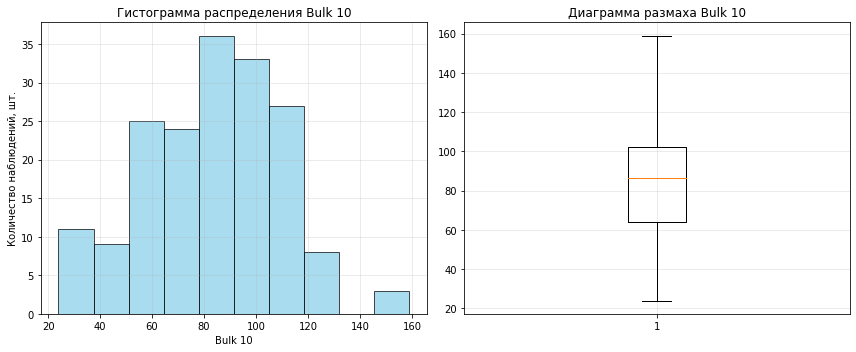

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

'Минимальное значение: 7.0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 159.0'

'Количество значений больше верхней границы: 0'

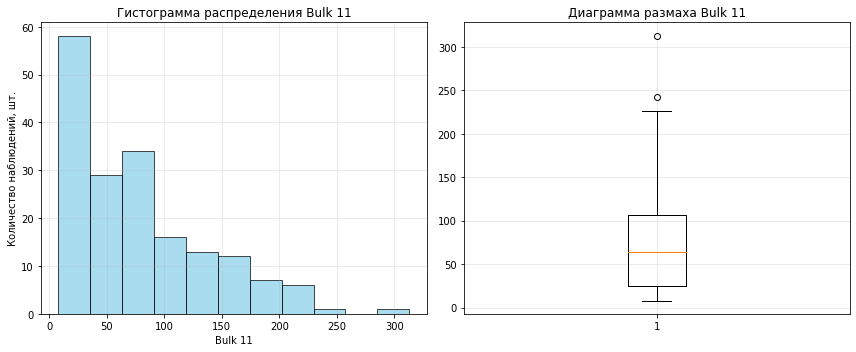

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 227.5'

'Количество значений больше верхней границы: 2'

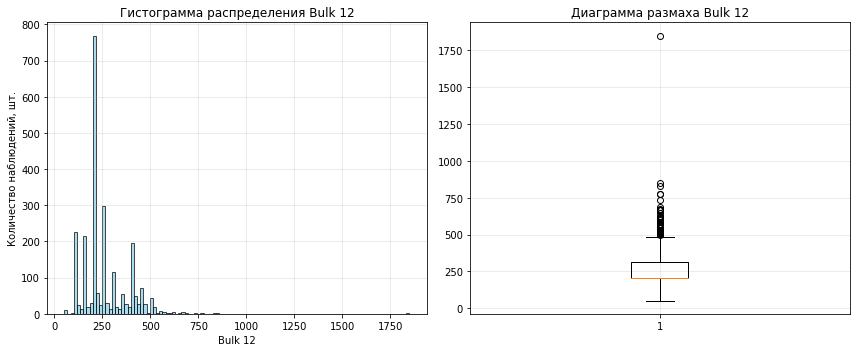

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

'Минимальное значение: 36.0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 484.0'

'Количество значений больше верхней границы: 102'

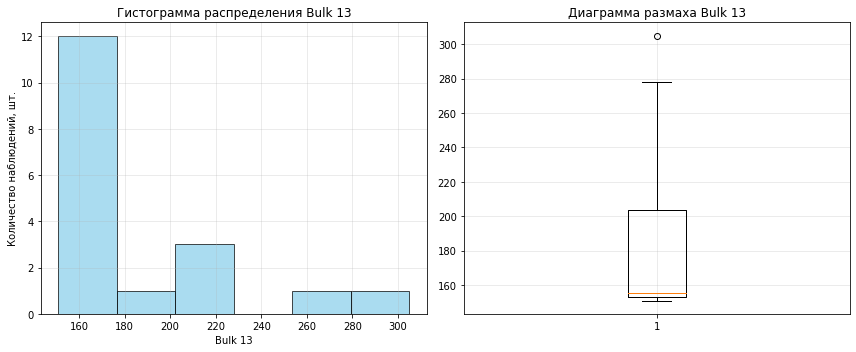

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

'Минимальное значение: 77.875'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 278.875'

'Количество значений больше верхней границы: 1'

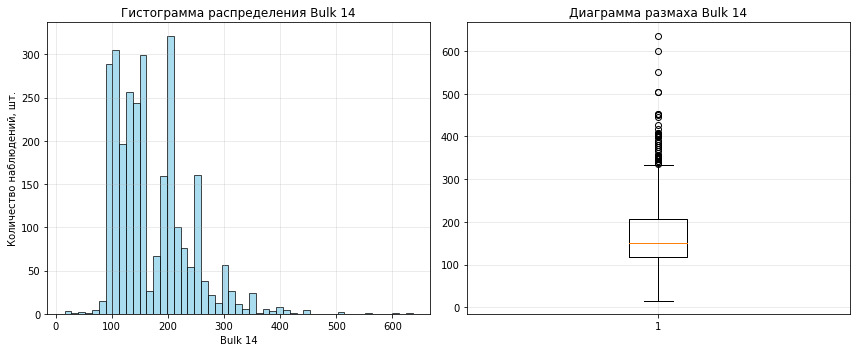

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 335.875'

'Количество значений больше верхней границы: 59'

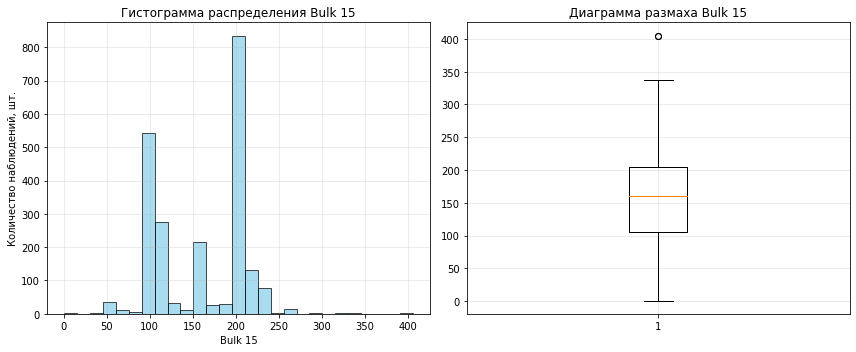

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 355.0'

'Количество значений больше верхней границы: 2'

'ДАТАФРЕЙМ: data_wire_time_new'

'ДАТАФРЕЙМ: data_wire_time_new'

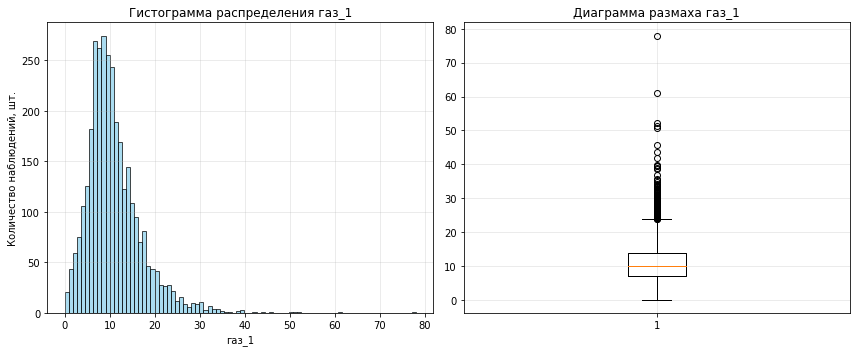

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: газ_1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 23.860155585675002'

'Количество значений больше верхней границы: 126'

'ДАТАФРЕЙМ: data_wire_time_new'

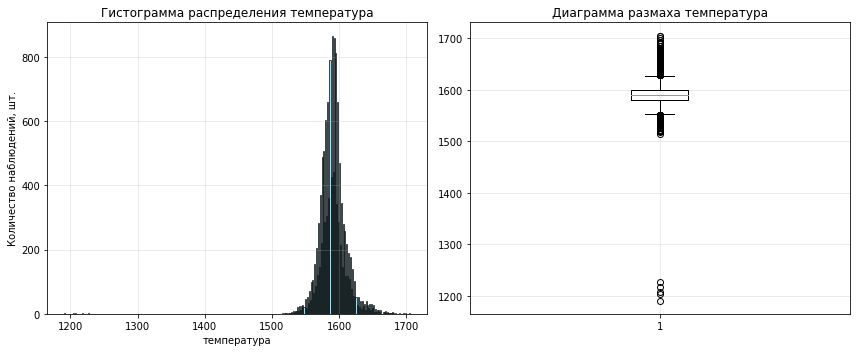

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

'Минимальное значение: 1551.5'

'Количество значений меньше нижней границы: 268'

'Максимальное значение: 1627.5'

'Количество значений больше верхней границы: 567'

'ДАТАФРЕЙМ: data_wire_time_new'

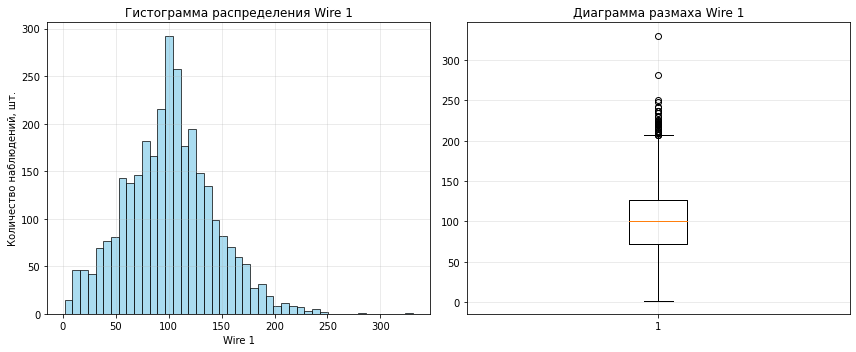

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 206.97768274999999'

'Количество значений больше верхней границы: 36'

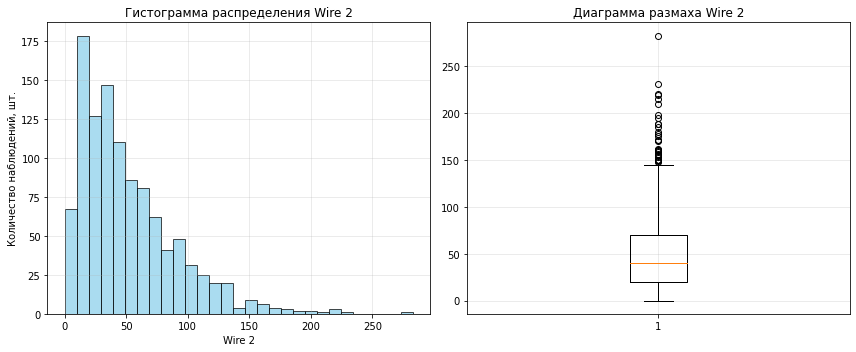

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 145.27837499999998'

'Количество значений больше верхней границы: 32'

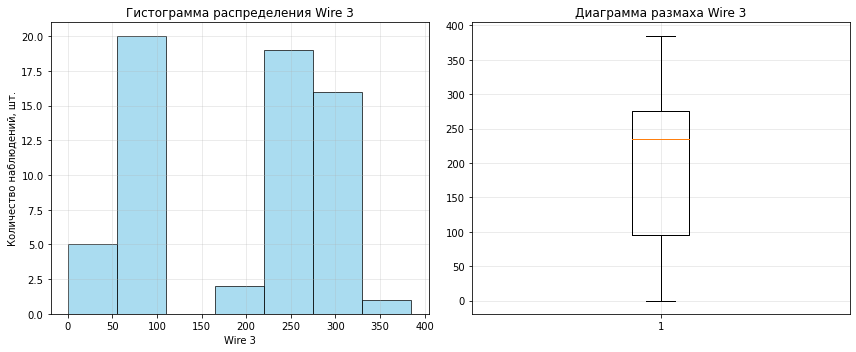

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 547.9274702499999'

'Количество значений больше верхней границы: 0'

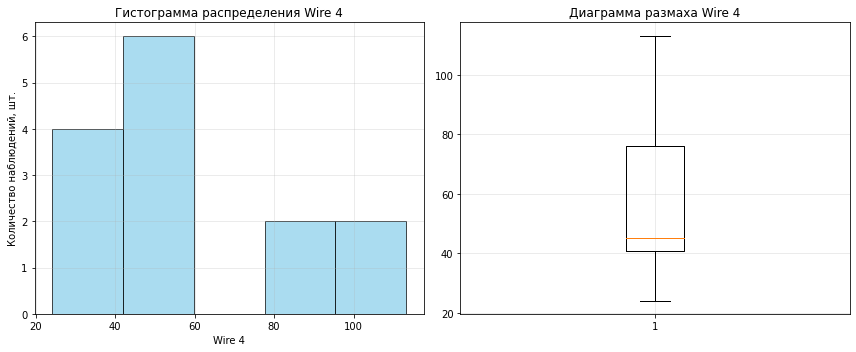

count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 129.10104487499999'

'Количество значений больше верхней границы: 0'

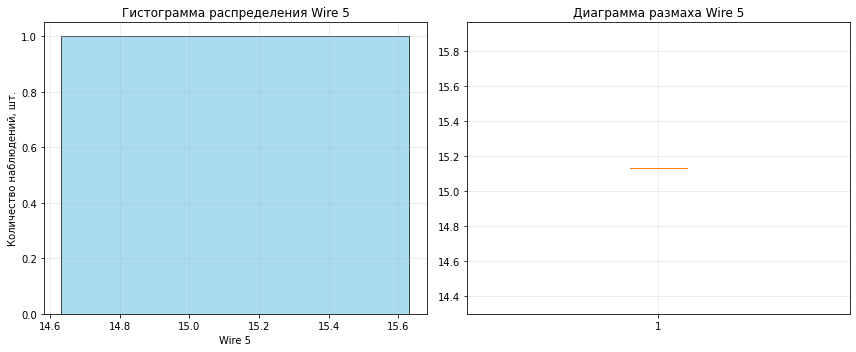

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

'Минимальное значение: 15.132'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 15.132'

'Количество значений больше верхней границы: 0'

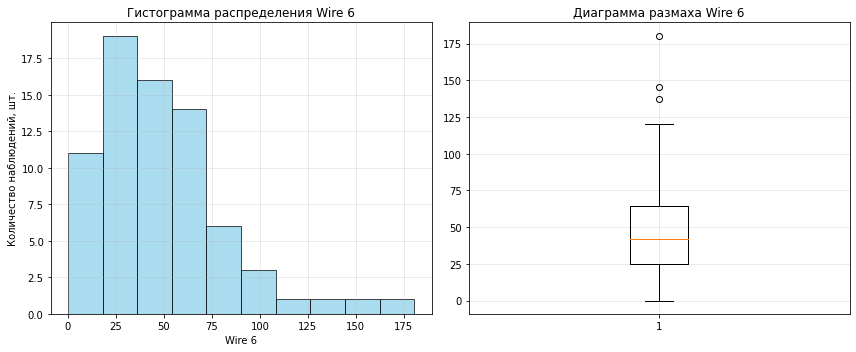

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 122.95140750000002'

'Количество значений больше верхней границы: 3'

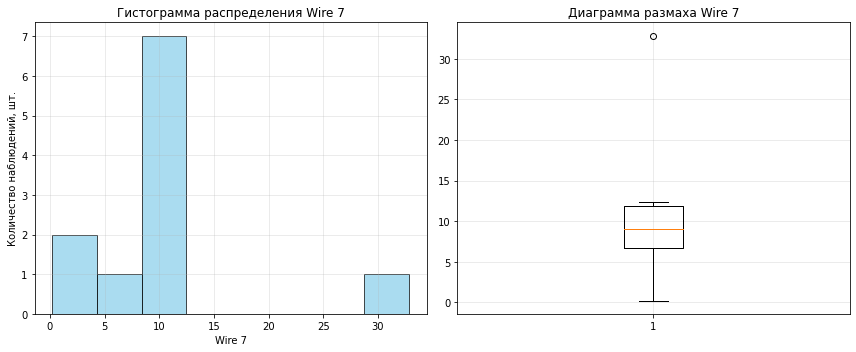

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 19.5710085'

'Количество значений больше верхней границы: 1'

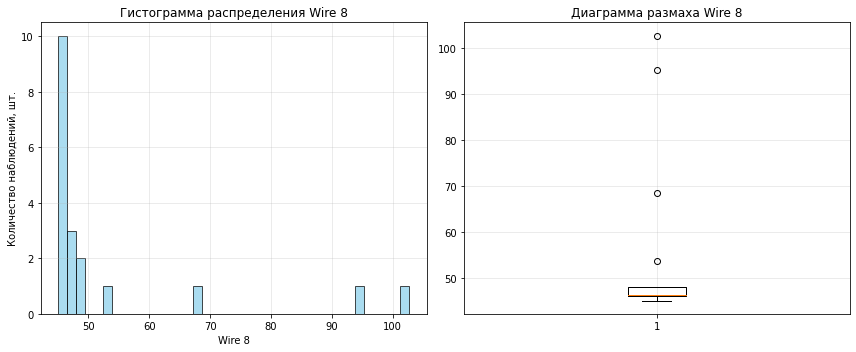

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

'Минимальное значение: 43.102793000000005'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 51.081689'

'Количество значений больше верхней границы: 4'

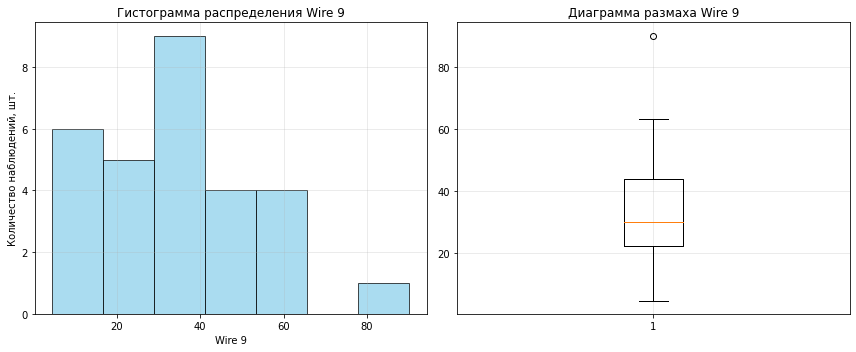

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 76.567406'

'Количество значений больше верхней границы: 1'

'ДАТАФРЕЙМ: data_wire_time_new'

In [13]:
eda_func_num_df(df_list)

**Датафрейм `data_arc_new.csv`** — данные об электродах;

Распределение значений активной мощности скошено влево. Среднее значение активной мощности составляет 0.66, медианное - 0.59. Присутствуют статистические выбросы выше верхней границы, но удалять их не будем - такие значения находятся в рамках произвоственного процесса.

Распределение значений реактивной мощности имеет аномальное значение (отрицательное) - его мы удалим и посмотрим на распределение позже еще раз.

**Датафрейм `data_bulk_new.csv`** — данные о подаче сыпучих материалов (объём);

Мы имеем разные сыпущие материалы от 1 от 15. Аномальных значений (в нашем случае отрицательных) не наблюдаем. Как ожидалось, для каждого сыпучего материала разные распределения (поскольку в каждой партии разные сыпущие материалы могли подаваться, а могли и нет).

**Датафрейм `data_gas_new.csv`** — данные о продувке сплава газом;

Мы видим похожее на нормальное распределение данных о подаче газа. Также видим большое количество выбросов выше верхней границы, однако такие выбросы - нормальны для производственного процесса, поэтому удалять их не будем.

**Датафрейм `data_temp_new.csv`** — результаты измерения температуры;

Из-за наличия в данных низких температур (ниже 1300) распределение на гистограмме смещено вправо. Данные ниже 1300 мы удалим и посмотрим на новое распределение.

**Датафрейм `data_wire_new.csv`** — данные о проволочных материалах (объём);

У нас в распоряжении данные о 9 проволочных материалах. Также не наблюдаем аномальных данных, ест статистические выбросы, но они нормальны в рамках производственного процесса. Для материала 1 наблюдаем похожее на нормальное распределение, для материала 2 - распределение Пуассона, для материалов 3,4,6,7,8 нормальных распределений не наблюдаем. Для материала 5 известно одно значение.

Мы видим аномальные значения в реактивной мощности - отрицательные значения. Также есть значения температуры меньше 1300 - такая температура не является нормальной при плавлении стали. Поэтому такие данные мы тоже удалим, а еще уберем информацию о тех партиях, где всего было меньше 2-х замеров.

In [14]:
data_arc_new = data_arc_new[data_arc_new['реактивная_мощность'] > 0]
data_temp_new = data_temp_new[data_temp_new['температура'] >= 1300]
data_temp_new['количество_замеров'] = data_temp_new.groupby('key')['температура'].transform('count')
data_temp_new = data_temp_new[data_temp_new['количество_замеров'] >= 2].drop('количество_замеров', axis=1)

In [15]:
df_list_new =[data_arc_new, data_temp_new]

'ДАТАФРЕЙМ: data_wire_time_new'

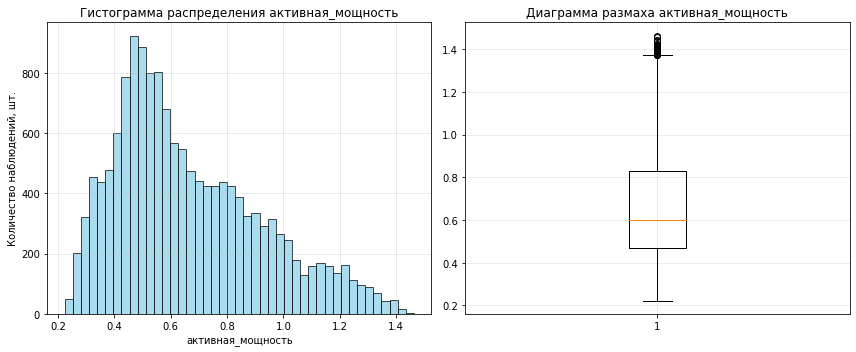

count    14875.000000
mean         0.662749
std          0.258894
min          0.223120
25%          0.467115
50%          0.599578
75%          0.830135
max          1.463773
Name: активная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.3746662499999998'

'Количество значений больше верхней границы: 72'

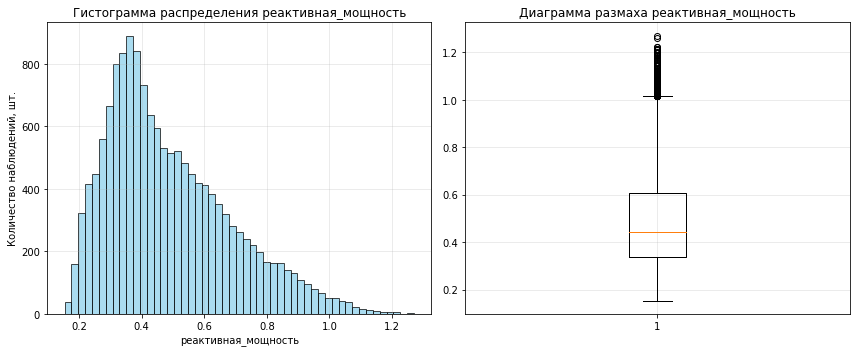

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: реактивная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.0147732499999997'

'Количество значений больше верхней границы: 198'

'ДАТАФРЕЙМ: data_wire_time_new'

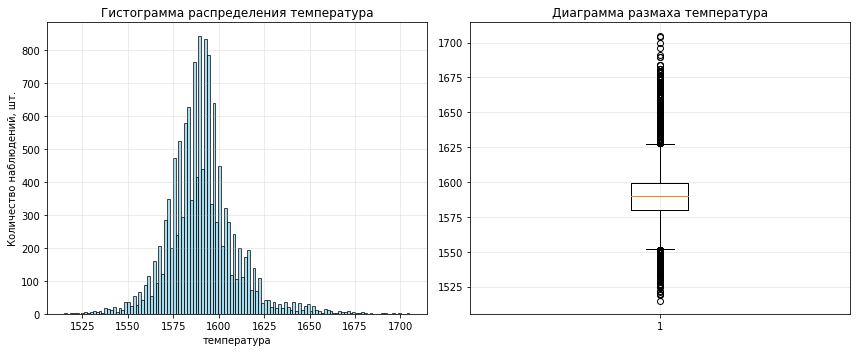

count    13920.000000
mean      1590.911494
std         18.774355
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

'Минимальное значение: 1551.5'

'Количество значений меньше нижней границы: 216'

'Максимальное значение: 1627.5'

'Количество значений больше верхней границы: 511'

In [16]:
eda_func_num_df(df_list_new)

**Датафрейм `data_arc_new.csv`** — данные об электродах;

Мы удалили одно аномальное значение и теперь наше распределение практически приобрело нормальный вид :) Имеются выбросы в рамках норамльных значений

**Датафрейм `data_temp_new.csv`** — результаты измерения температуры;

Распределение значений температуры также приобрело нормальный вид.

Корреляционный анализ имеет делать смысл, когда мы объединим все данные и сможем оценить влияние всех признаков друг на друга и на таргет. А также оценить, стоит ли добавить новые признаки (например - вместо активной мощности использовать полную формулу мощности).

В объединение мы добавим все данные о добавленных материалах, газе, мощностях, соответсующих начальным и конечным значеняим температуры для каждой партии.

## Объединение данных

In [17]:
data_temp_new.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [18]:
data_arc_new.head(10)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Можем заметить, что Время замера соотвествует времени, когда начали нагревать сплав дугой. Найлем для каждой партии минимальное и максимальное время замера.

In [19]:
# Сначала сортируем по времени для каждой партии
temp_sorted = data_temp_new.sort_values(['key', 'время_замера'])

# Затем находим первую и последнюю запись для каждой партии
result = temp_sorted.groupby('key').agg(
    начальное_время=('время_замера', 'first'),
    конечное_время=('время_замера', 'last'),
    начальная_температура=('температура', 'first'),
    конечная_температура=('температура', 'last')
).reset_index()

result

,key,начальное_время,конечное_время,начальная_температура,конечная_температура
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0


In [20]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2475 non-null   int64         
 1   начальное_время        2475 non-null   datetime64[ns]
 2   конечное_время         2475 non-null   datetime64[ns]
 3   начальная_температура  2475 non-null   float64       
 4   конечная_температура   2475 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.8 KB


In [21]:
time_tolerance = pd.Timedelta('10 seconds')

merged_df = pd.merge_asof(
    result.sort_values('начальное_время'),
    data_arc_new.sort_values('начало_нагрева_дугой'),
    left_on='начальное_время',
    right_on='начало_нагрева_дугой',
    left_by='key',
    right_by='key',
    direction='nearest',
    tolerance=time_tolerance
)

merged_df

,key,начальное_время,конечное_время,начальная_температура,конечная_температура,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,2019-05-03 12:39:37,2019-05-03 12:43:04,0.642946,0.516071
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,2019-05-03 13:11:13,2019-05-03 13:15:24,0.324563,0.279102
...,...,...,...,...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,2019-08-10 11:27:57,2019-08-10 11:31:24,0.430979,0.359487
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,2019-08-10 11:56:58,2019-08-10 11:58:55,0.333029,0.228362
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,2019-08-10 12:37:36,2019-08-10 12:40:12,1.268378,0.859087
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,2019-08-10 12:58:21,2019-08-10 13:02:37,0.419017,0.295789


Присоединим данные по ключу к merge_df

In [22]:
all_df = [merged_df, data_gas_new, data_bulk_new, data_wire_new]

result = reduce(lambda left, right: pd.merge(left, right, on='key', how='inner'), all_df)

In [23]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2329 non-null   int64         
 1   начальное_время        2329 non-null   datetime64[ns]
 2   конечное_время         2329 non-null   datetime64[ns]
 3   начальная_температура  2329 non-null   float64       
 4   конечная_температура   2329 non-null   float64       
 5   начало_нагрева_дугой   2329 non-null   datetime64[ns]
 6   конец_нагрева_дугой    2329 non-null   datetime64[ns]
 7   активная_мощность      2329 non-null   float64       
 8   реактивная_мощность    2329 non-null   float64       
 9   газ_1                  2329 non-null   float64       
 10  bulk_1                 199 non-null    float64       
 11  bulk_2                 13 non-null     float64       
 12  bulk_3                 960 non-null    float64       
 13  bul

Отлично! Данные объединили, заменим пустые значения на 0.

In [24]:
df_full = result.fillna(0)

In [25]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2329 non-null   int64         
 1   начальное_время        2329 non-null   datetime64[ns]
 2   конечное_время         2329 non-null   datetime64[ns]
 3   начальная_температура  2329 non-null   float64       
 4   конечная_температура   2329 non-null   float64       
 5   начало_нагрева_дугой   2329 non-null   datetime64[ns]
 6   конец_нагрева_дугой    2329 non-null   datetime64[ns]
 7   активная_мощность      2329 non-null   float64       
 8   реактивная_мощность    2329 non-null   float64       
 9   газ_1                  2329 non-null   float64       
 10  bulk_1                 2329 non-null   float64       
 11  bulk_2                 2329 non-null   float64       
 12  bulk_3                 2329 non-null   float64       
 13  bul

Значения изменили, перейдем к исследовательскому анализу объединенного датафрейма

## Исследовательский анализ и предобработка данных объединённого датафрейма

Установим индексом поле `key`, добавим новое поле `heating_duration_min` - время нагрева дугой в минутах. Посомтрим на распределение данных, чтобы решить, какую корреляцию будем смотреть - Спирмана или Пирсона. В случае, если у нас будет много выбросов, а также если будет неравномерное распределение признаков, то лучше использовать корреляцию  Спирмана.

In [26]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2329 non-null   int64         
 1   начальное_время        2329 non-null   datetime64[ns]
 2   конечное_время         2329 non-null   datetime64[ns]
 3   начальная_температура  2329 non-null   float64       
 4   конечная_температура   2329 non-null   float64       
 5   начало_нагрева_дугой   2329 non-null   datetime64[ns]
 6   конец_нагрева_дугой    2329 non-null   datetime64[ns]
 7   активная_мощность      2329 non-null   float64       
 8   реактивная_мощность    2329 non-null   float64       
 9   газ_1                  2329 non-null   float64       
 10  bulk_1                 2329 non-null   float64       
 11  bulk_2                 2329 non-null   float64       
 12  bulk_3                 2329 non-null   float64       
 13  bul

In [27]:
df_full['heating_duration'] = df_full['конец_нагрева_дугой'] - df_full['начало_нагрева_дугой']
df_full['heating_duration'] = df_full['heating_duration'].dt.total_seconds()
df_full['heating_duration_min'] = df_full['heating_duration'] / 60

In [28]:
df_full['полная_мощность'] = np.sqrt(df_full['активная_мощность']**2 + df_full['реактивная_мощность']**2)

In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2329 non-null   int64         
 1   начальное_время        2329 non-null   datetime64[ns]
 2   конечное_время         2329 non-null   datetime64[ns]
 3   начальная_температура  2329 non-null   float64       
 4   конечная_температура   2329 non-null   float64       
 5   начало_нагрева_дугой   2329 non-null   datetime64[ns]
 6   конец_нагрева_дугой    2329 non-null   datetime64[ns]
 7   активная_мощность      2329 non-null   float64       
 8   реактивная_мощность    2329 non-null   float64       
 9   газ_1                  2329 non-null   float64       
 10  bulk_1                 2329 non-null   float64       
 11  bulk_2                 2329 non-null   float64       
 12  bulk_3                 2329 non-null   float64       
 13  bul

'ДАТАФРЕЙМ: data_wire_time_new'

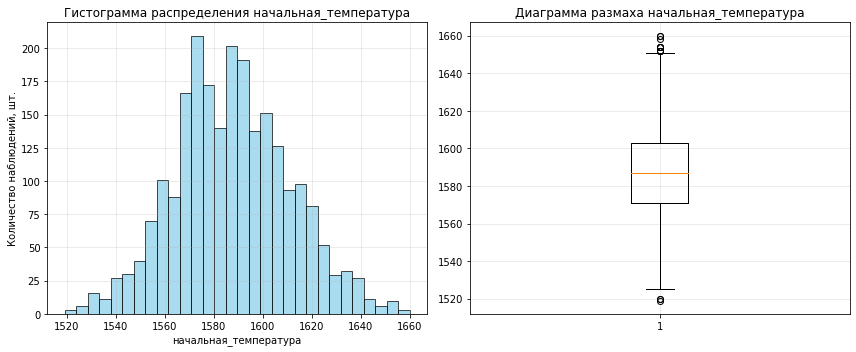

count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: начальная_температура, dtype: float64

'Минимальное значение: 1523.0'

'Количество значений меньше нижней границы: 3'

'Максимальное значение: 1651.0'

'Количество значений больше верхней границы: 11'

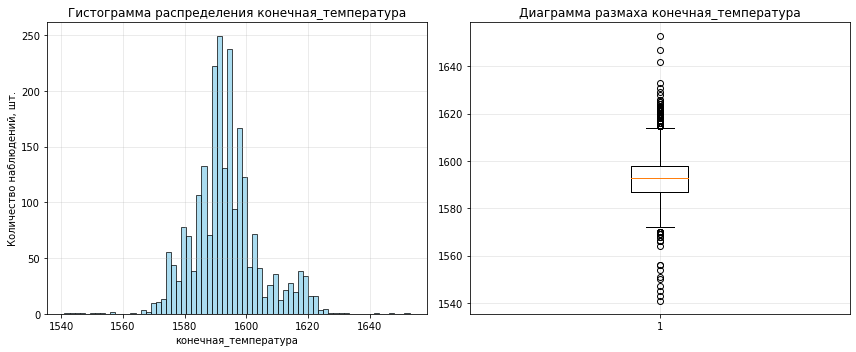

count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: конечная_температура, dtype: float64

'Минимальное значение: 1570.5'

'Количество значений меньше нижней границы: 25'

'Максимальное значение: 1614.5'

'Количество значений больше верхней границы: 156'

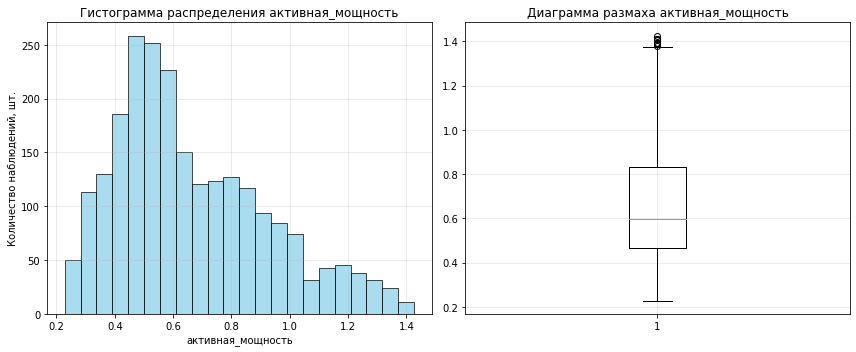

count    2329.000000
mean        0.662904
std         0.260562
min         0.228238
25%         0.467712
50%         0.597882
75%         0.830969
max         1.426122
Name: активная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.3758545'

'Количество значений больше верхней границы: 10'

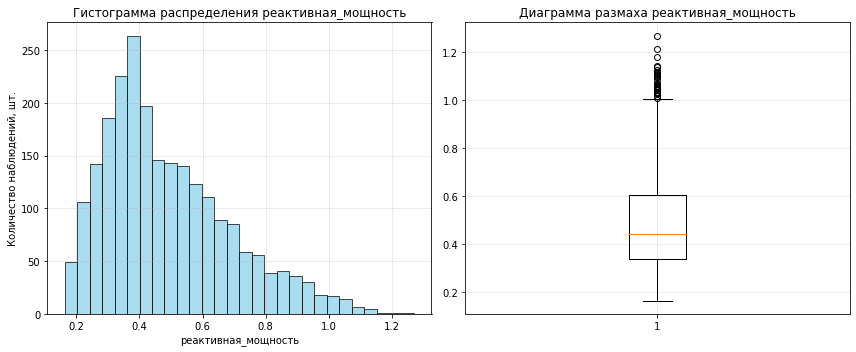

count    2329.000000
mean        0.487849
std         0.200026
min         0.163216
25%         0.337457
50%         0.439436
75%         0.606022
max         1.270284
Name: реактивная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.0088694999999999'

'Количество значений больше верхней границы: 34'

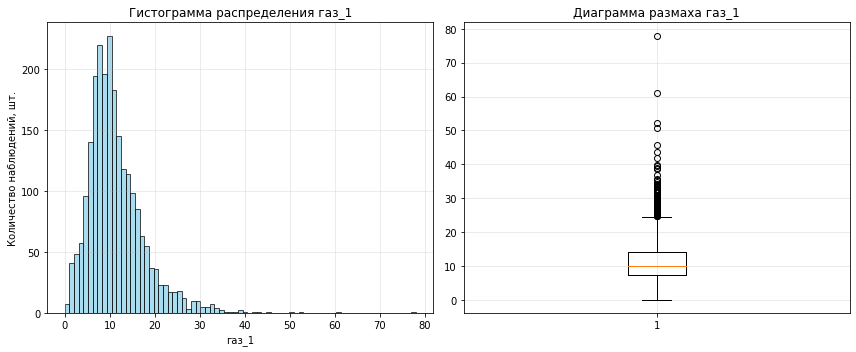

count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: газ_1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 24.617297991'

'Количество значений больше верхней границы: 93'

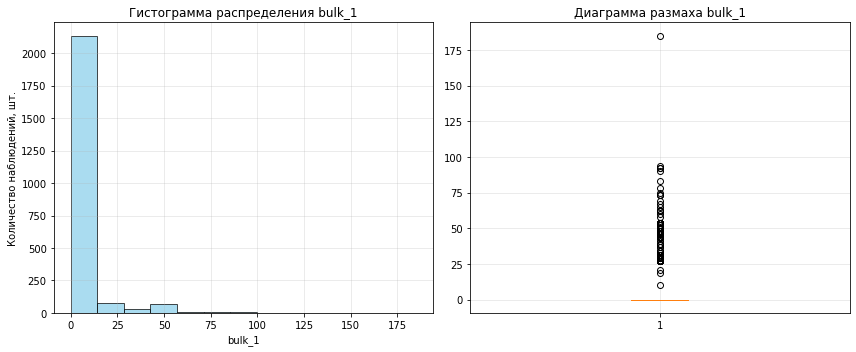

count    2329.000000
mean        3.427651
std        12.412132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: bulk_1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 199'

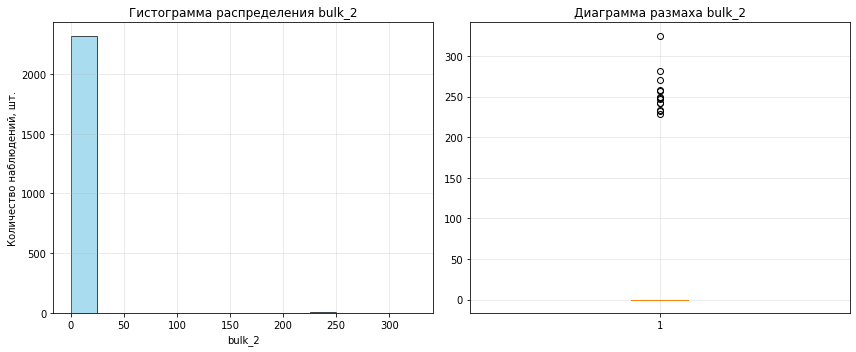

count    2329.000000
mean        1.422499
std        19.082119
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: bulk_2, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 13'

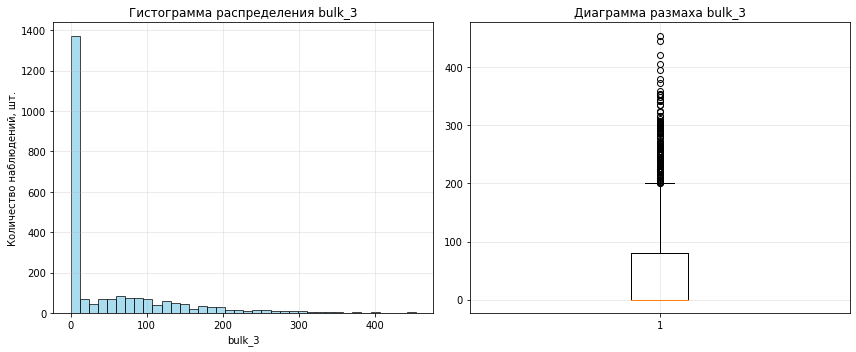

count    2329.000000
mean       47.348218
std        75.310430
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: bulk_3, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 200.0'

'Количество значений больше верхней границы: 129'

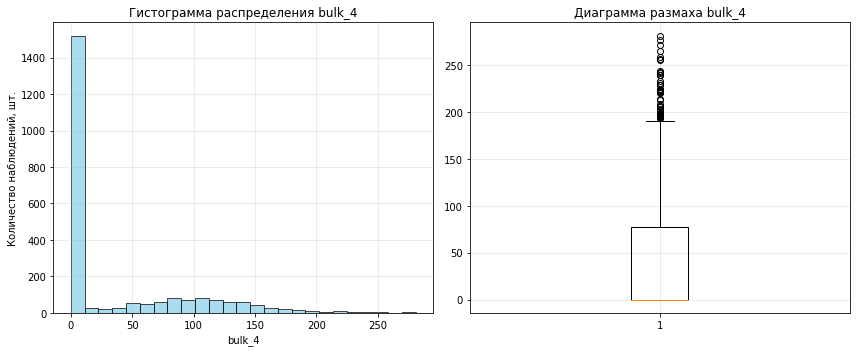

count    2329.000000
mean       37.303564
std        58.643238
min         0.000000
25%         0.000000
50%         0.000000
75%        77.000000
max       281.000000
Name: bulk_4, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 192.5'

'Количество значений больше верхней границы: 46'

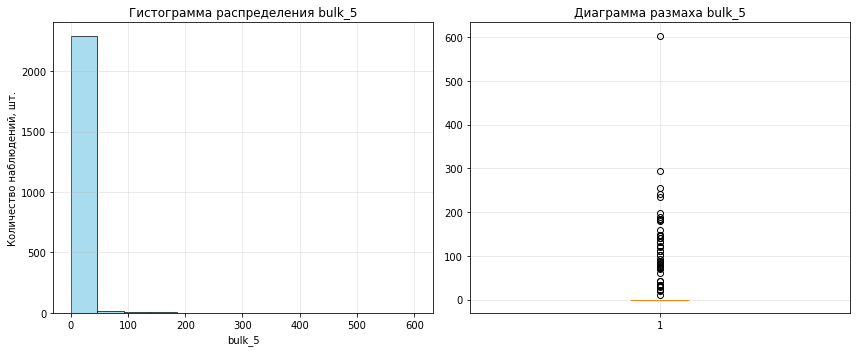

count    2329.000000
mean        2.640189
std        22.402293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: bulk_5, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 53'

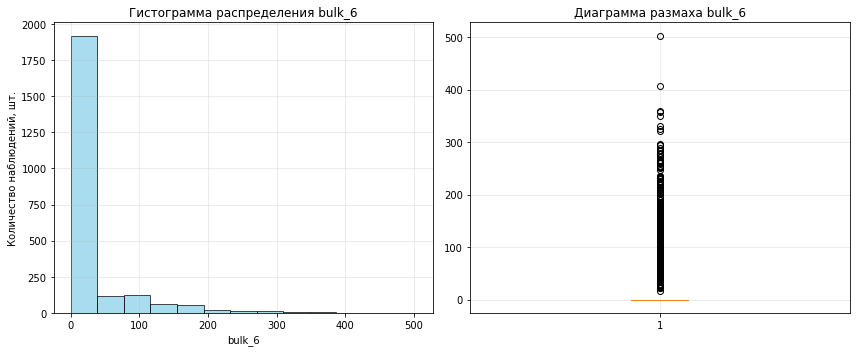

count    2329.000000
mean       22.430228
std        55.790873
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: bulk_6, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 438'

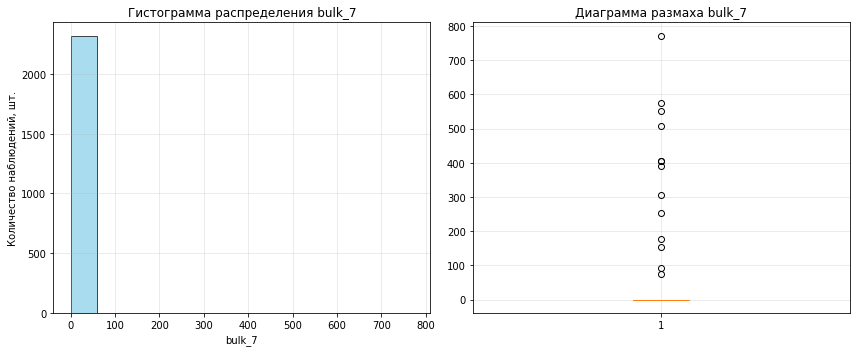

count    2329.000000
mean        2.004723
std        30.676234
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: bulk_7, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 13'

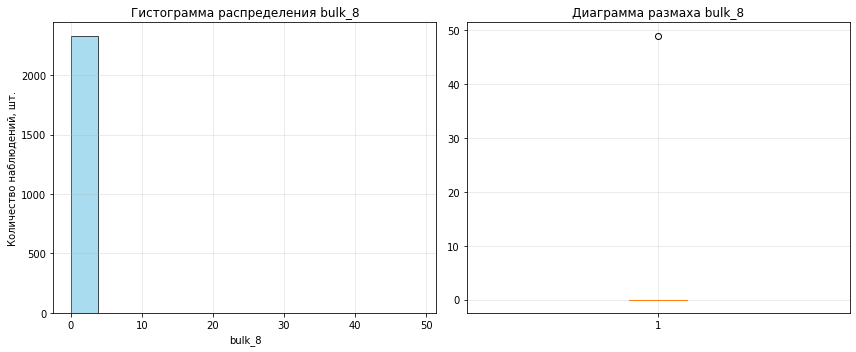

count    2329.000000
mean        0.021039
std         1.015340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: bulk_8, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 1'

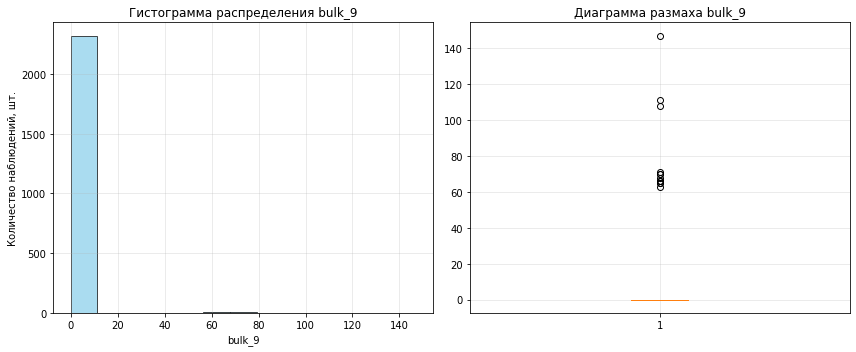

count    2329.000000
mean        0.444826
std         6.220641
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: bulk_9, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 13'

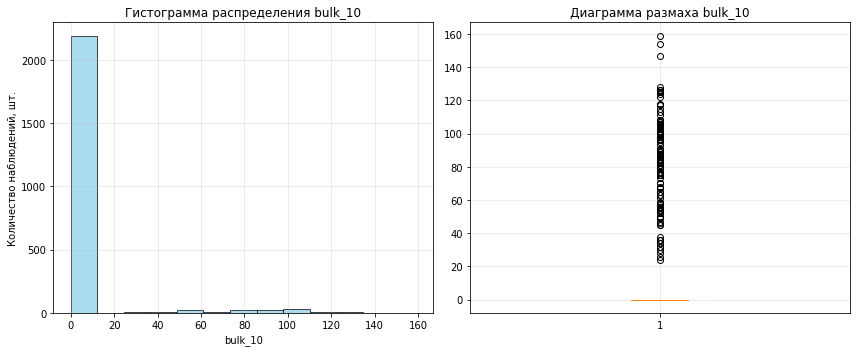

count    2329.000000
mean        5.052812
std        20.917800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: bulk_10, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 143'

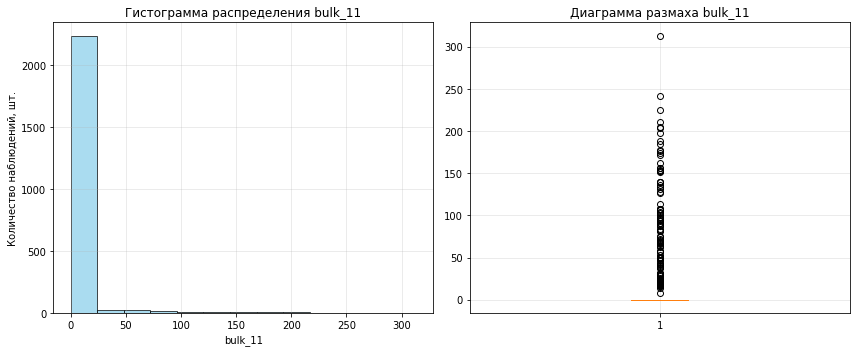

count    2329.000000
mean        4.245170
std        22.515487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: bulk_11, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 130'

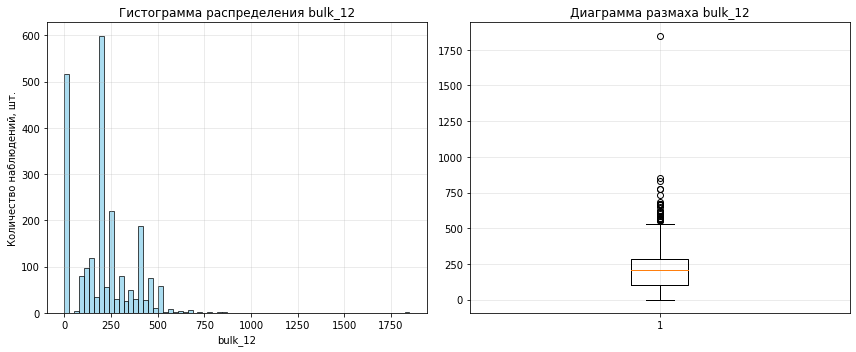

count    2329.000000
mean      208.415629
std       157.062272
min         0.000000
25%       105.000000
50%       206.000000
75%       282.000000
max      1849.000000
Name: bulk_12, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 547.5'

'Количество значений больше верхней границы: 32'

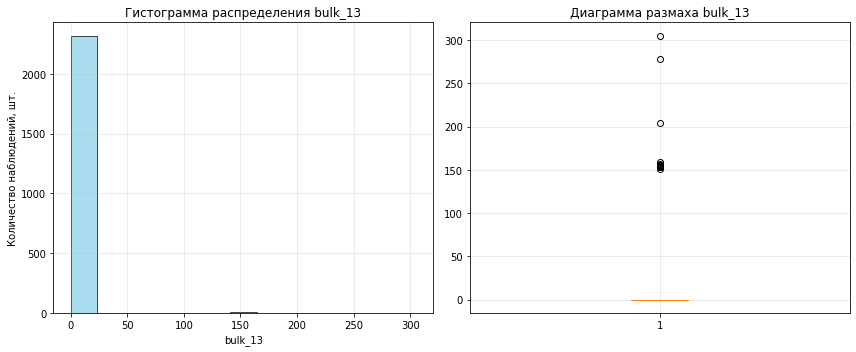

count    2329.000000
mean        1.067411
std        14.235055
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       305.000000
Name: bulk_13, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 14'

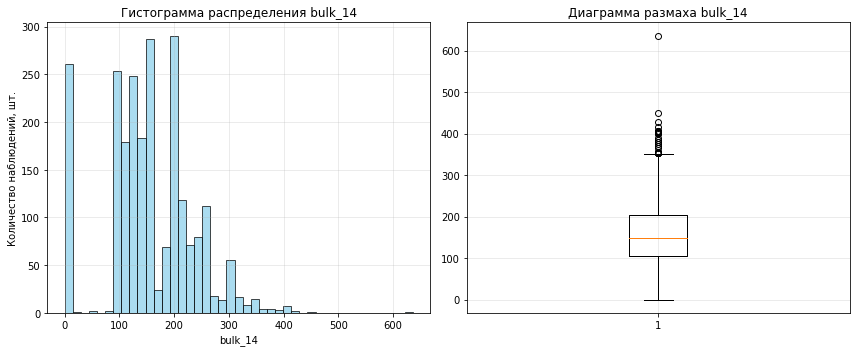

count    2329.000000
mean      153.853585
std        81.404354
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 352.5'

'Количество значений больше верхней границы: 28'

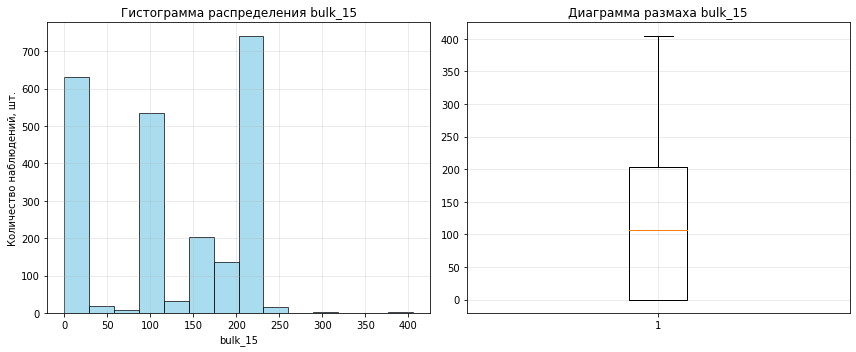

count    2329.000000
mean      119.952769
std        84.640443
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 510.0'

'Количество значений больше верхней границы: 0'

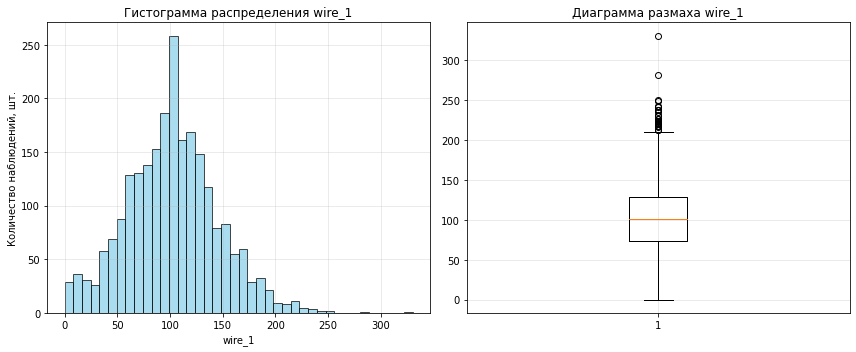

count    2329.000000
mean      102.443601
std        43.539993
min         0.000000
25%        73.207679
50%       101.119201
75%       128.091599
max       330.314424
Name: wire_1, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 210.41747900000001'

'Количество значений больше верхней границы: 28'

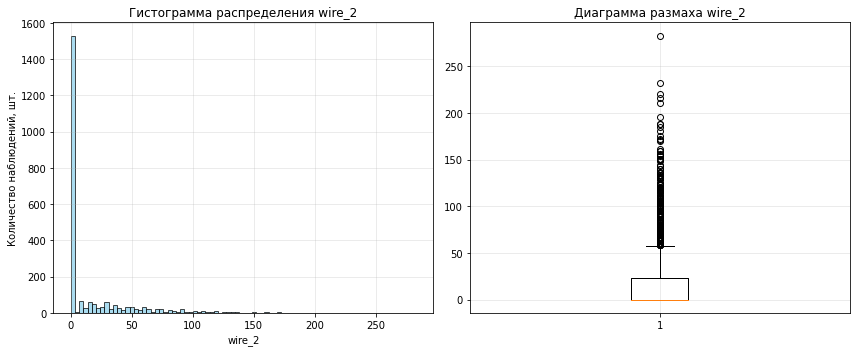

count    2329.000000
mean       17.609859
std        33.624771
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: wire_2, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 57.7564'

'Количество значений больше верхней границы: 272'

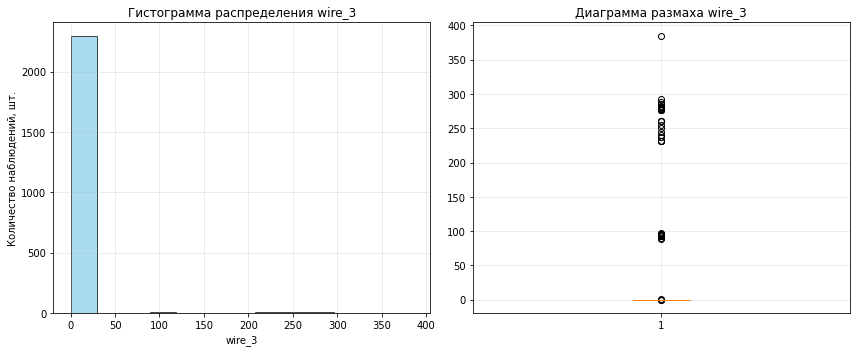

count    2329.000000
mean        3.234916
std        27.942871
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: wire_3, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 39'

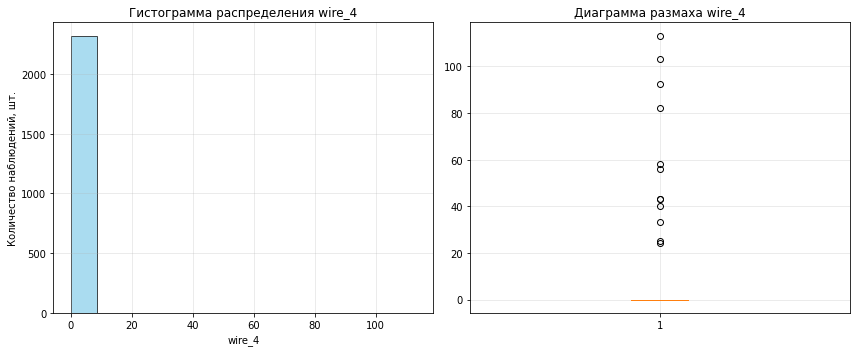

count    2329.000000
mean        0.306550
std         4.757746
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: wire_4, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 12'

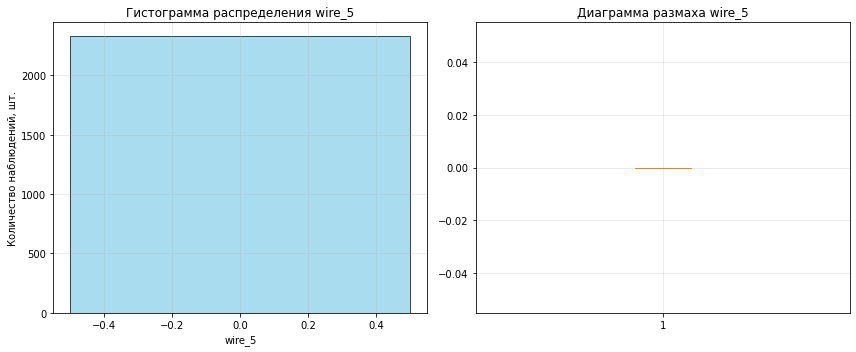

count    2329.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: wire_5, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 0'

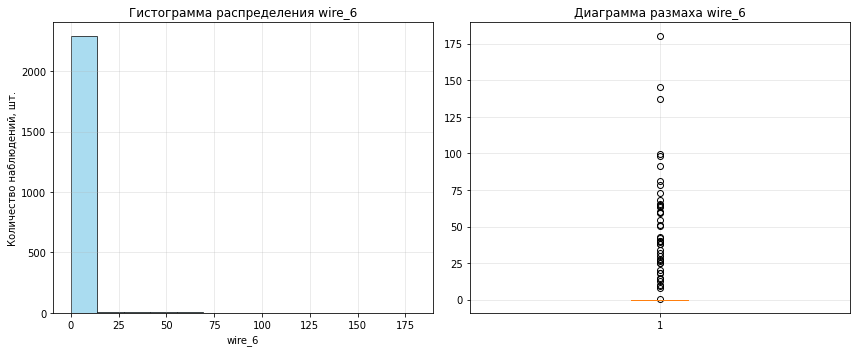

count    2329.000000
mean        0.978820
std         8.693299
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: wire_6, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 45'

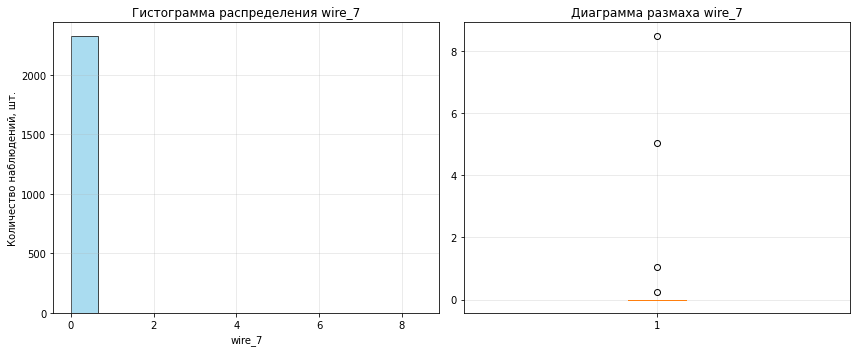

count    2329.000000
mean        0.006361
std         0.205705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: wire_7, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 4'

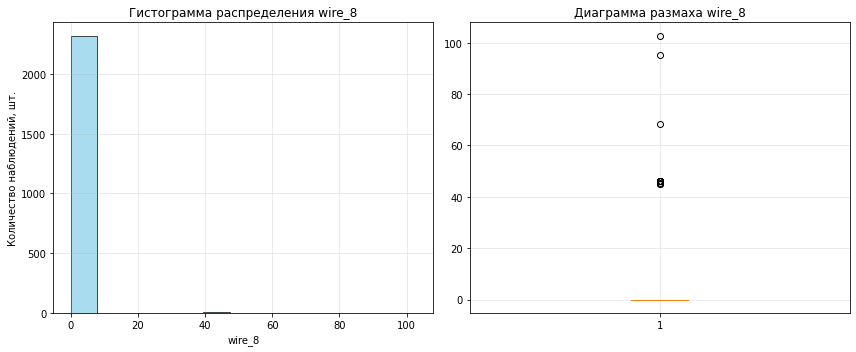

count    2329.000000
mean        0.311311
std         4.402707
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: wire_8, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 13'

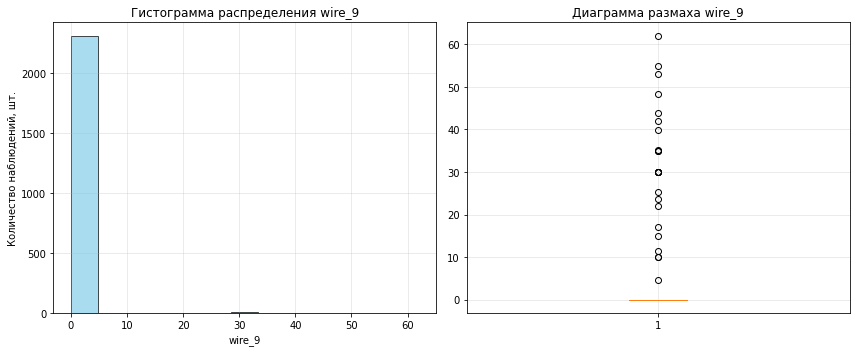

count    2329.000000
mean        0.317113
std         3.456561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: wire_9, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 0.0'

'Количество значений больше верхней границы: 24'

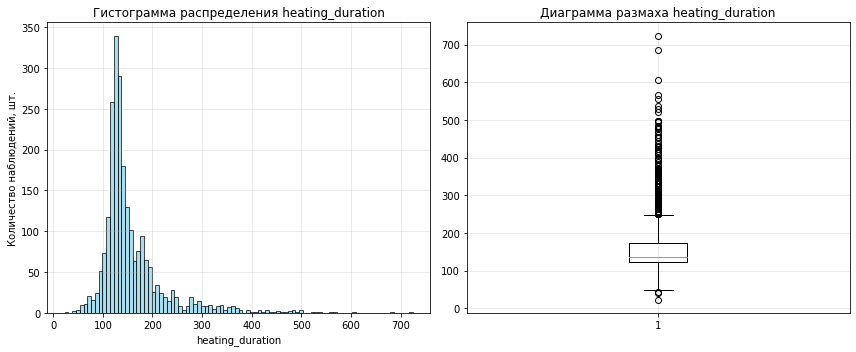

count    2329.000000
mean      157.257621
std        67.377754
min        23.000000
25%       122.000000
50%       136.000000
75%       173.000000
max       724.000000
Name: heating_duration, dtype: float64

'Минимальное значение: 45.50000000000004'

'Количество значений меньше нижней границы: 3'

'Максимальное значение: 249.49999999999997'

'Количество значений больше верхней границы: 183'

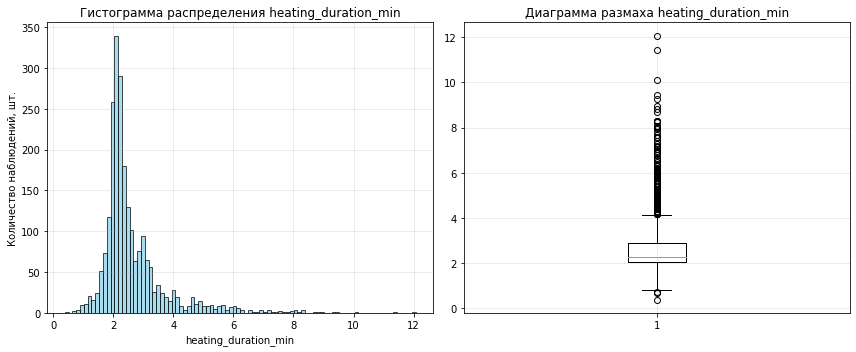

count    2329.000000
mean        2.620960
std         1.122963
min         0.383333
25%         2.033333
50%         2.266667
75%         2.883333
max        12.066667
Name: heating_duration_min, dtype: float64

'Минимальное значение: 0.7583333333333342'

'Количество значений меньше нижней границы: 3'

'Максимальное значение: 4.158333333333333'

'Количество значений больше верхней границы: 183'

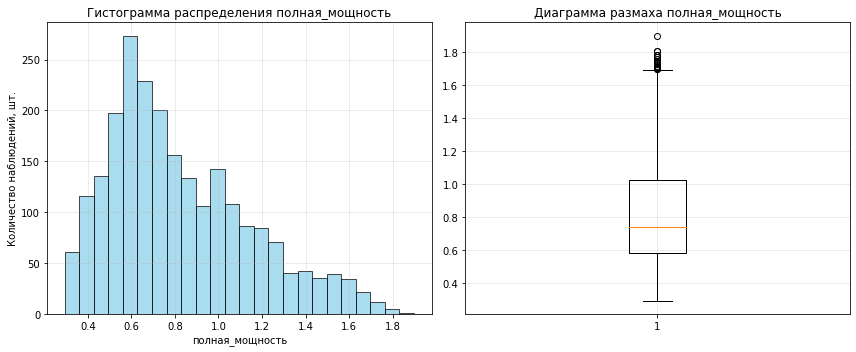

count    2329.000000
mean        0.823932
std         0.326308
min         0.293682
25%         0.579331
50%         0.741836
75%         1.025754
max         1.898158
Name: полная_мощность, dtype: float64

'Минимальное значение: 0'

'Количество значений меньше нижней границы: 0'

'Максимальное значение: 1.69538828550028'

'Количество значений больше верхней границы: 19'

In [30]:
eda_func_num_df([df_full])

In [31]:
df_full = df_full.set_index('key')
df_full = df_full.drop(columns=['начальное_время', \
                                'конечное_время', 'начало_нагрева_дугой', \
                                'конец_нагрева_дугой', 'heating_duration', 'активная_мощность', 'реактивная_мощность'])

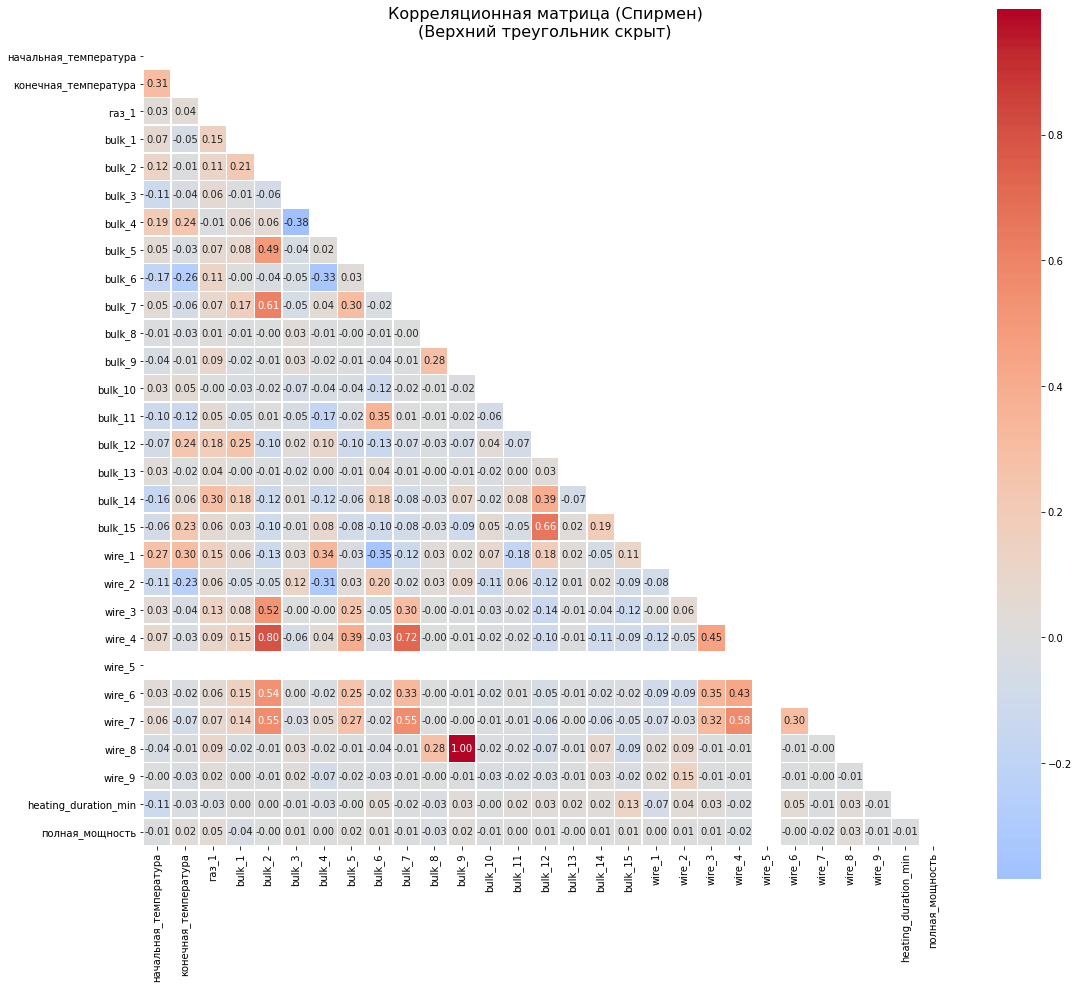

In [32]:
correlation_matrix = df_full.corr(method='spearman')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            mask=mask, # применяем маску
            linewidths=0.5)
plt.title('Корреляционная матрица (Спирмен)\n(Верхний треугольник скрыт)', fontsize=16)
plt.show()

Мы видим, что у нас признак `wire_5` никак не влияет ни на один другой признак. Посмотрим на уникальные значения этого признака.

In [33]:
df_full['wire_5'].unique()

array([0.])

Есть смысл удалить этот признак из таблицы. Также если рассматривать все признаки, мы можем заметить, что у нас очень мало признаков с умеремнной корреляцией и выше (по Спирману), а также достаточно признаков с мультиколлинеарностью. Предлагаем сделать новую корреляционную матрицу с отфильтрованными значениями корреляции Спирмана выше 0.4 по модулю.

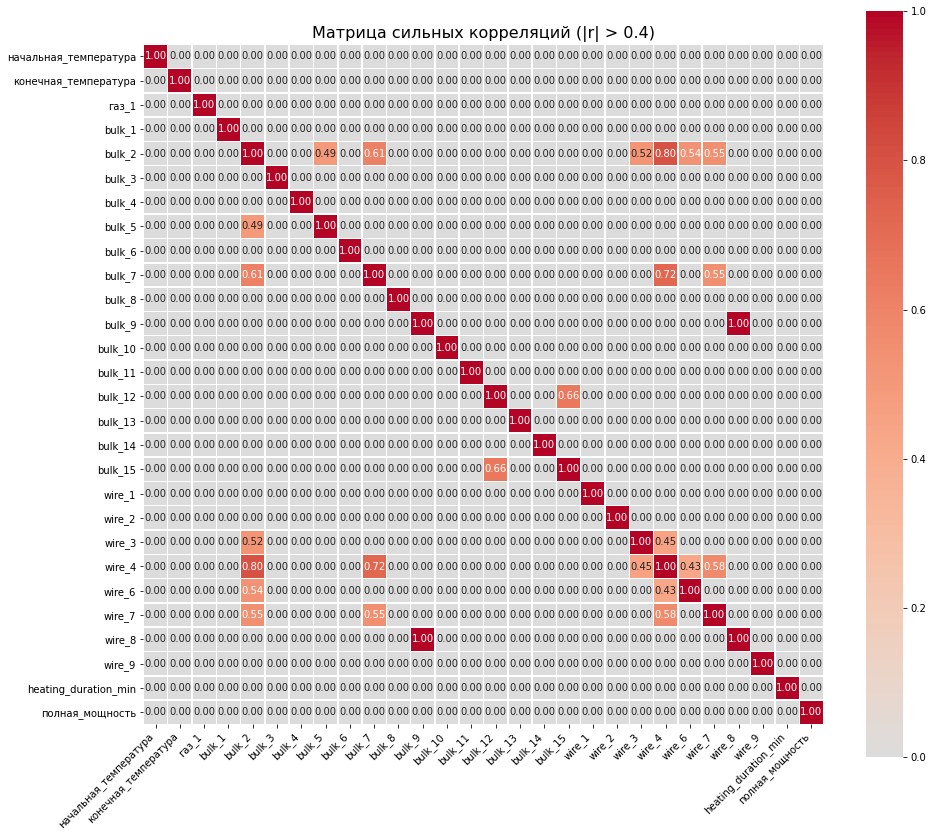

In [34]:
df_full = df_full.drop(columns=['wire_5'])
corr_matrix = df_full.corr(method='spearman')

strong_corr_matrix = corr_matrix.copy()
strong_corr_matrix[np.abs(strong_corr_matrix) < 0.4] = 0  # Обнуляем все |r| < 0.4

has_strong_corr = strong_corr_matrix.columns[(strong_corr_matrix.abs() > 0).any()]

filtered_corr_matrix = strong_corr_matrix.loc[has_strong_corr, has_strong_corr]

plt.figure(figsize=(14, 12))
sns.heatmap(filtered_corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5)
plt.title('Матрица сильных корреляций (|r| > 0.4)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Теперь мы видим, что на целевой признак - конечную температуру - не влияет ни один признак. При этом мы наблюдаем мультиколлинеарность между следующими признаками:

- wire_8 и bulk_9 - 1.00 - сильная корреляция, однако ни один из этих признаков не влияет сильно на целевой признак, поэтому их можно удалить
- wire_4 и bulk_2 - 0.80 - сильная прямая корреляция
- wire_4 и bulk_7 - 0.72 - сильная прямая корреляция
- bulk_7 и bulk_2 - 0.61 - сильная прямая корреляция
- wire_7 и bulk_2, wire_7 и bulk_7 - 0.55 - умеренная корреляция
- wire_6 и bulk_2 - 0.54 - умеренная корреляция
- wire_3 и bulk_2 - 0.52 - умеренная корреляция
- bulk_5 и bulk_2 - 0.49 - умеренная корреляция

Таким образом, мы предлагаем убрать из обучения данные о bulk_2, bulk_7, bulk_9, wire_4, wire_8. Однако мы будем использовать бустинг модели, в которых можно использовать даже скорелированные между собой признаки, поэтому оставим все признаки, как есть.

In [36]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   начальная_температура  2329 non-null   float64
 1   конечная_температура   2329 non-null   float64
 2   газ_1                  2329 non-null   float64
 3   bulk_1                 2329 non-null   float64
 4   bulk_2                 2329 non-null   float64
 5   bulk_3                 2329 non-null   float64
 6   bulk_4                 2329 non-null   float64
 7   bulk_5                 2329 non-null   float64
 8   bulk_6                 2329 non-null   float64
 9   bulk_7                 2329 non-null   float64
 10  bulk_8                 2329 non-null   float64
 11  bulk_9                 2329 non-null   float64
 12  bulk_10                2329 non-null   float64
 13  bulk_11                2329 non-null   float64
 14  bulk_12                2329 non-null   float64
 15  bulk

Данные преобработали, перейдем к подготовке данных и обучению моделей.

## Подготовка данных и обучение моделей

Мы решили объединить два шага по подготовке и обучению данных в один, поскольку будем использовать пайплайн.

In [37]:
RANDOM_STATE = 250825
TEST_SIZE = 0.25

# разделяем датасет на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['конечная_температура'], axis=1),
    df_full['конечная_температура'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)


base_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])


scalers = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
    PowerTransformer(method='yeo-johnson'),
    PowerTransformer(method='box-cox'),  # Только для положительных данных
    QuantileTransformer(n_quantiles=100, output_distribution='normal'),
    QuantileTransformer(n_quantiles=100, output_distribution='uniform'),
    'passthrough'
]

param_grids = {
    'LinearRegression': {
        'model': [LinearRegression()],
        'scaler': scalers,
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'Ridge': {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 4, 50),
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'scaler': scalers,
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'Lasso': {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 2, 50),
        'model__selection': ['cyclic', 'random'],
        'scaler': scalers,
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'ElasticNet': {
        'model': [ElasticNet(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 2, 30),
        'model__l1_ratio': np.linspace(0.1, 1.0, 10),
        'model__selection': ['cyclic', 'random'],
        'scaler': scalers,
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'RandomForest': {
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [None, 10, 20, 30, 40, 50],
        'model__min_samples_split': [2, 5, 10, 15],
        'model__min_samples_leaf': [1, 2, 4, 8],
        'model__max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8],
        'model__bootstrap': [True, False],
        'scaler': ['passthrough'],
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'GradientBoosting': {
        'model': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5, 6, 7, 8],
        'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 'log2', None],
        'scaler': ['passthrough'],
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'XGBoost': {
        'model': [xgb.XGBRegressor(random_state=RANDOM_STATE, verbosity=0)],
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__gamma': [0, 0.1, 0.2, 0.5, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5, 1.0, 5.0],
        'model__reg_lambda': [0.5, 1.0, 1.5, 2.0, 5.0],
        'scaler': ['passthrough'],
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    },

    'CatBoost': {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'model__iterations': [500, 800, 1000],
        'model__learning_rate': [0.005, 0.01, 0.05, 0.1],
        'model__depth': [4, 6, 8],
        'model__l2_leaf_reg': [1, 3, 5],
        'model__border_count': [32, 64, 128],
        'model__random_strength': [1.0, 2.0],
        'model__grow_policy': ['SymmetricTree', 'Depthwise'],
        'scaler': ['passthrough'],
        'imputer__strategy': ['mean', 'median', 'most_frequent']
    }
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = {}

In [38]:
for model_name, param_grid in param_grids.items():
    print(f"\n=== Тuning {model_name} ===")

    randomized_search = RandomizedSearchCV(
        base_pipeline,
        param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
        n_iter=50
    )

    randomized_search.fit(X_train, y_train)

    results[model_name] = {
        'best_estimator': randomized_search.best_estimator_,
        'best_score': randomized_search.best_score_,
        'best_params': randomized_search.best_params_,
        'cv_results': randomized_search.cv_results_
    }



=== Тuning LinearRegression ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Тuning Ridge ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning Lasso ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning ElasticNet ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning RandomForest ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning GradientBoosting ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning XGBoost ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits

=== Тuning CatBoost ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits


## Выбор лучшей модели и проверка качества на тестовой выборке

In [41]:
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Best_MAE': [-results[model]['best_score'] for model in results],
    'Best_Params': [results[model]['best_params'] for model in results]
}).sort_values('Best_MAE')

comparison_df

,Model,Best_MAE,Best_Params
5,GradientBoosting,7.096533,"{'scaler': 'passthrough', 'model__subsample': ..."
6,XGBoost,7.115544,"{'scaler': 'passthrough', 'model__subsample': ..."
7,CatBoost,7.118533,"{'scaler': 'passthrough', 'model__random_stren..."
4,RandomForest,7.170618,"{'scaler': 'passthrough', 'model__n_estimators..."
3,ElasticNet,7.322781,"{'scaler': MinMaxScaler(), 'model__selection':..."
2,Lasso,7.328666,"{'scaler': RobustScaler(), 'model__selection':..."
1,Ridge,7.334774,"{'scaler': 'passthrough', 'model__solver': 'sa..."
0,LinearRegression,7.412379,"{'scaler': PowerTransformer(), 'model': Linear..."


In [42]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['best_estimator']

In [43]:
y_test_pred = best_model.predict(X_test)
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, y_test_pred)}')

Метрика MAE на тестовой выборке: 6.786370755878877


Метрика MAE на тестовой выборке равна 6.78. Посмотрим, как справится dummy регрессия.

## Проверка на Dummy Regressor

In [44]:
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy, X_train, y_train,
                              cv=cv, scoring='neg_mean_absolute_error')

print(f"Dummy Regressor CV MAE: {-dummy_scores.mean():.4f} (±{dummy_scores.std():.4f})")

Dummy Regressor CV MAE: 8.2815 (±0.2680)


Т.к. ошибка на dummy регрессии выше, чем на нашей модели, мы можем утверждать, что наша модель справляется лучшего простого подбора средних значений.

Поcмотрим на анализ признаков нашей модели

## Анализ важности признаков

Важность признаков XGBoost:
                  feature  importance
0   начальная_температура    0.182385
17                 wire_1    0.167756
16                bulk_15    0.084897
13                bulk_12    0.082060
15                bulk_14    0.079288
18                 wire_2    0.064030
1                   газ_1    0.061842
7                  bulk_6    0.059833
2                  bulk_1    0.046850
8                  bulk_7    0.027655
5                  bulk_4    0.026394
25   heating_duration_min    0.022436
26        полная_мощность    0.021340
22                 wire_7    0.012030
4                  bulk_3    0.010005


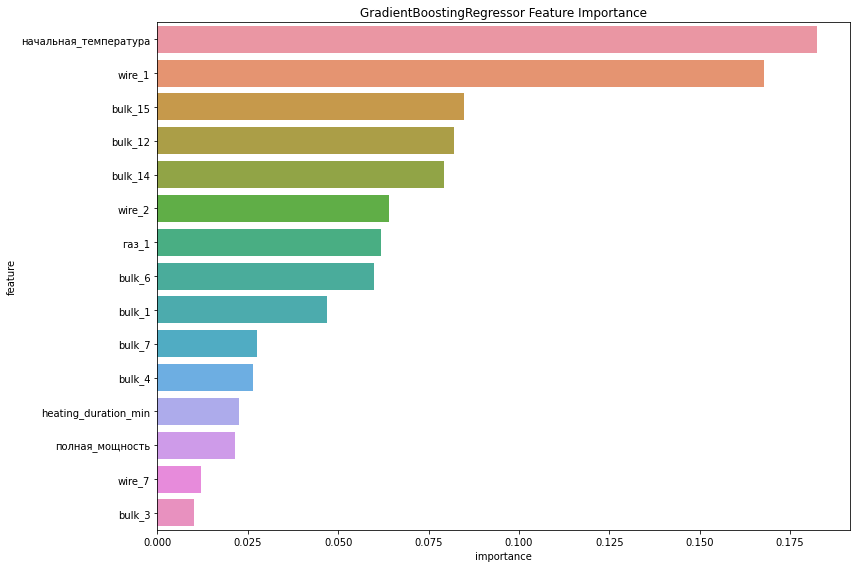

In [45]:
model = best_model.named_steps['model']
feature_names = X_train.columns.tolist()

importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Важность признаков XGBoost:")
print(importance_df.head(15))


plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('GradientBoostingRegressor Feature Importance')
plt.tight_layout()
plt.show()

Permutation Importance (топ-15):
                  feature  importance_mean  importance_std
0   начальная_температура     1.352215e-01        0.029418
16                bulk_15     4.911642e-02        0.018400
15                bulk_14     3.493527e-02        0.007294
18                 wire_2     2.522067e-02        0.012234
13                bulk_12     2.015883e-02        0.013713
2                  bulk_1     1.744127e-02        0.008359
7                  bulk_6     1.609014e-02        0.009657
17                 wire_1     1.333655e-02        0.014036
1                   газ_1     1.288170e-02        0.005474
8                  bulk_7     1.158139e-02        0.001504
22                 wire_7     8.570616e-03        0.000362
20                 wire_4     4.970178e-03        0.000396
23                 wire_8     1.770253e-05        0.000000
10                 bulk_9     1.086527e-05        0.000006
24                 wire_9     6.084580e-07        0.000002


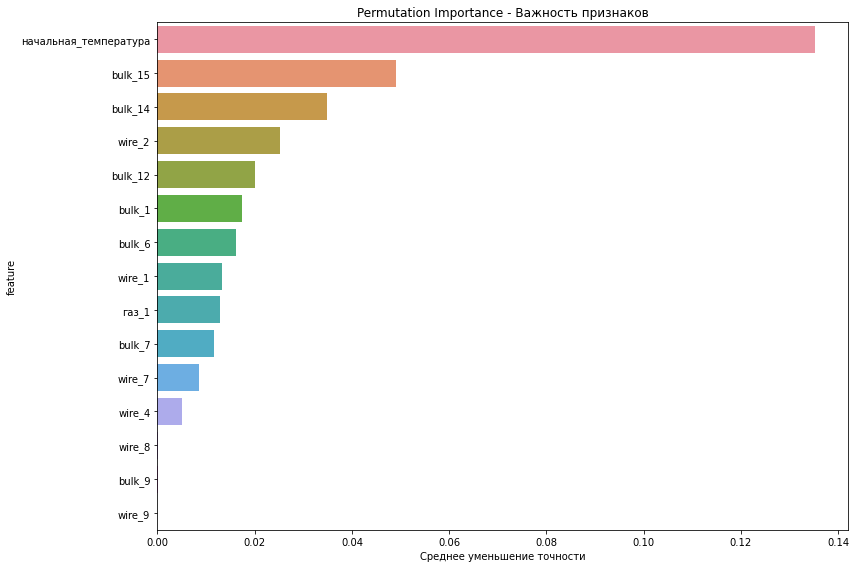

In [46]:
perm_importance = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': X_train.columns.tolist(),
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Permutation Importance (топ-15):")
print(perm_df.head(15))


plt.figure(figsize=(12, 8))
sns.barplot(data=perm_df.head(15), x='importance_mean', y='feature')
plt.title('Permutation Importance - Важность признаков')
plt.xlabel('Среднее уменьшение точности')
plt.tight_layout()
plt.show()

Мы видим, что главным признаком в нашей модели является начальная температура, а далее идут признаки, связанные с материалами, добавляемыми в сплав.

## Выводы

Мы получили на вход данные, предобработали и провели исследовательский анализ. Затем объединили данные в один датафрейм, провели еще один исследовательский анализ и выявили с помощью корреляционной матрицы те метрики, которые могут быть полезны, или которые необходимо убрать из датасета для избавления от мультиколлинераности.

Далее для преобработки и обучения модели мы сделали пайплайн, в котором использовали следующие модели: LinearModel, Ridge, Random Forest, Gradient Boosting, XGBoost, LightGBM, CatBoost. Лучше всех на кросс-валидации себя показала модель Gradient Boosting, на тестовой выборке значение метрики MAE равно 6.85.

Также мы сделали проверку на dummy regressor, при кросс-валидации данная модель показала значение метрики MAE 8.28, что говорит о том, что наша модель предсказывает значения лучше, чем простой подбор средних.

Анализ важности признаков показал, что важнее всех была начальная температура в партии, а далее по списку шли значения материалов, добавляемых в сплав. Значения, которые мы сгенерировали самостоятельно (полная мощность и время нагрева) не попали в топ 15 признаков у модели, поэтому эти данные, вероятно в дальнейшем нет смысла использовать (температур аначала и конца в целом предопределяет мощность электродов)

Рекомендации к заказчику: добавить больше уточняющих признаков, влияющих на температуру сплава.